In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import mintpy
import gdal
from mintpy.utils import plot as pp
from mintpy.utils import readfile, utils as ut 
import h5py
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mintpy import view
from mintpy.objects import timeseries
from operator import itemgetter 
import datetime
from datetime import timedelta
from scipy import interpolate
import matplotlib.dates as mdates
from minopy.objects.invert_pixel import process_pixel 
from scipy import stats
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [3]:
prj = '/Users/Sara/Documents/insarlab/scratch/SicilySenDT124'

prj_dirs = [os.path.join(prj, x) for x in ['minopy_single_reference', 'minopy_mini_stacks/geocoded', 'minopy_seq_2', 'minopy_seq_8', 'delaunay_4_network/geocoded']]

thrs = [0.5, 0.5, 0.5, 0.5, 0.7]
out_dir = './out_figures'


view.py /Users/Sara/Documents/insarlab/scratch/SicilySenDT124/minopy_single_reference/velocity.h5 velocity -m /Users/Sara/Documents/insarlab/scratch/SicilySenDT124/minopy_single_reference/maskTempCoh.h5 --notitle --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noscalebar --noverbose --nomultilook --sub-lat 36.97 37.09 --sub-lon 15.17 15.33 -v -4 4 --ref-lalo 37.0901 15.2864
view.py /Users/Sara/Documents/insarlab/scratch/SicilySenDT124/minopy_mini_stacks/geocoded/velocity.h5 velocity -m /Users/Sara/Documents/insarlab/scratch/SicilySenDT124/minopy_mini_stacks/geocoded/maskTempCoh.h5 --notitle --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noscalebar --noverbose --nomultilook --sub-lat 36.97 37.09 --sub-lon 15.17 15.33 -v -4 4 --ref-lalo 37.0901 15.2864
view.py /Users/Sara/Documents/insarlab/scratch/SicilySenDT124/minopy_seq_2/velocity.h5

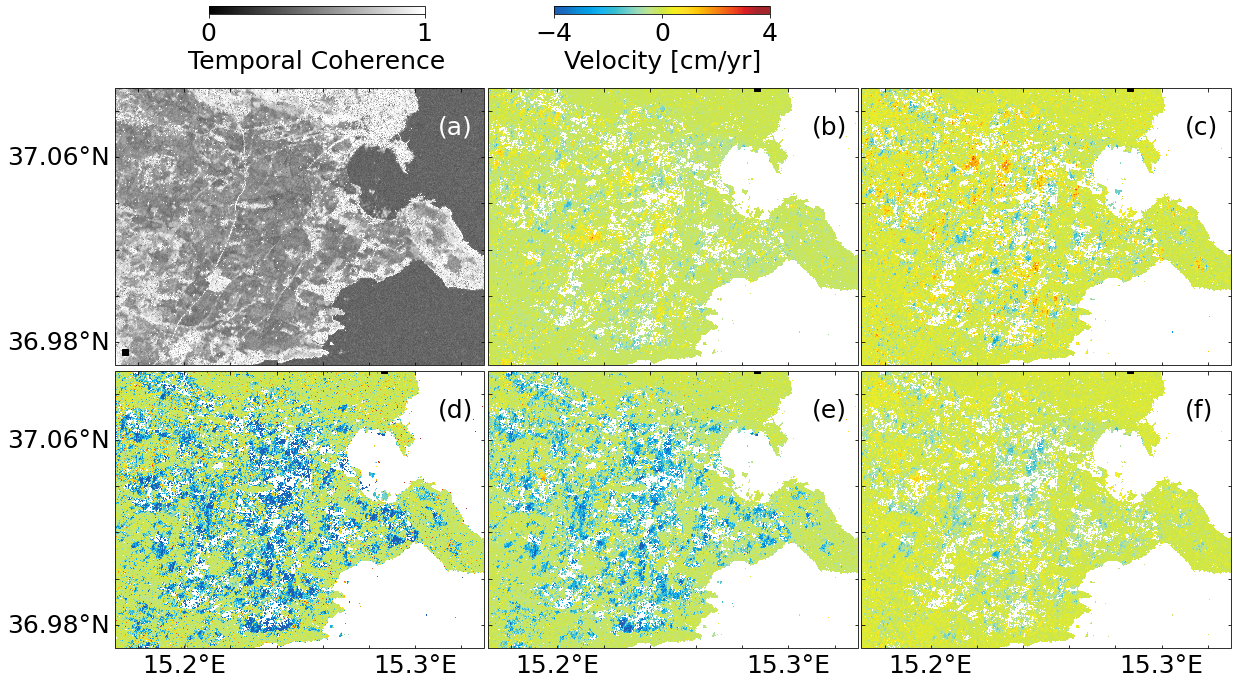

In [22]:
plt.rcParams["font.size"] = "25"

box = ['36.97:37.09','15.17:15.33']
reflat = 37.0901
reflon = 15.2864

lat = [float(i) for i in box[0].split(':')]
lon = [float(i) for i in box[1].split(':')]

opt = ' --notitle --nocbar --alpha 1 '
opt += ' --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature '
opt += ' --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noscalebar'
opt += ' --noverbose --nomultilook ' #.format(reflat, reflon)


fig, axs = plt.subplots(nrows=2, ncols=3, 
                        figsize=(20,10.3), subplot_kw=dict(projection=ccrs.PlateCarree()))

col = [1, 2, 0, 1, 2]
row = [0, 0, 1, 1, 1]
labels = ['(b)', '(c)', '(d)', '(e)', '(f)']

for i in range(len(prj_dirs)):

    ax = axs[row[i], col[i]]
    ax.set_extent([lon[0], lon[1], lat[0], lat[1]], crs=ccrs.PlateCarree())
    
    data_lass = os.path.join(prj_dirs[i], 'velocity.h5')
    mask_lass = os.path.join(prj_dirs[i], 'maskTempCoh.h5')

    cmd = 'view.py {} velocity -m {}'.format(data_lass, mask_lass) + opt 

    cmd += ' --sub-lat {} {} --sub-lon {} {} '.format(lat[0], lat[1], lon[0], lon[1])
    cmd += ' -v -{f} {f} --ref-lalo {d1} {d2}'.format(f=4, d1=reflat, d2=reflon)
    
    d_v, atr, inps = view.prep_slice(cmd)
    im, cbar = view.plot_slice(ax, d_v, atr, inps)[2:4]
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0, color='black', alpha=0.5, linestyle='--', draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_left = False
    gl.ylabels_right=False
    gl.xlabels_bottom=False   
    gl.xlines = True
    gl.xlocator = mticker.FixedLocator([15.20, 15.30])
    gl.ylocator = mticker.FixedLocator([36.98, 37.06])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    if i == 2:
        gl.ylabels_left = True
    if i in [2,3,4]:
        gl.xlabels_bottom=True
        
    ax.text(15.31, 37.07, labels[i])
        


cbar_ax = fig.add_axes([0.43, 0.98, 0.15, 0.01])
fig.colorbar(im, cax=cbar_ax, ticks=[-4, 0, 4], label='Velocity [cm/yr]', orientation='horizontal')


ax = axs[0,0]
ax.set_extent([lon[0], lon[1], lat[0], lat[1]], crs=ccrs.PlateCarree())

data_lass = os.path.join(prj_dirs[0], 'temporalCoherence.h5')
opt = ' --notitle --nocbar --alpha 1 '
opt += ' --lalo-step 0.02 --lalo-loc 0 0 0 0 -c gray '
opt += ' --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noscalebar'
opt += ' --noverbose --nomultilook ' #.format(reflat, reflon)
cmd = 'view.py {} -v 0 1'.format(data_lass) + opt 
cmd += ' --sub-lat {} {} --sub-lon {} {} '.format(lat[0], lat[1], lon[0], lon[1])
d_v, atr, inps = view.prep_slice(cmd)
im, cbar = view.plot_slice(ax, d_v, atr, inps)[2:4]

cbar_ax = fig.add_axes([0.19, 0.98, 0.15, 0.01])
fig.colorbar(im, cax=cbar_ax, ticks=[0, 1], label='Temporal Coherence', orientation='horizontal')

ax.text(15.31, 37.07, '(a)', color='white')

gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0, color='black', alpha=0.5, linestyle='--', draw_labels=True)
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right=False
gl.xlabels_bottom=False   
gl.xlines = True
gl.xlocator = mticker.FixedLocator([15.20, 15.30])
gl.ylocator = mticker.FixedLocator([36.98, 37.06])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

fig.subplots_adjust(hspace=0.02, wspace=0.01)


plt.savefig(out_dir +'/Sicily.png', bbox_inches='tight', dpi=300) 


view.py /Users/Sara/Documents/insarlab/scratch/SicilySenDT124/minopy_seq_2/new/geo/geo_Trip_perc.h5 --notitle --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c jet --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noscalebar --noverbose --nomultilook --sub-lat 36.97 37.09 --sub-lon 15.17 15.33
view.py /Users/Sara/Documents/insarlab/scratch/SicilySenDT124/minopy_seq_8/new/geo/geo_Trip_perc.h5 --notitle --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c jet --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noscalebar --noverbose --nomultilook --sub-lat 36.97 37.09 --sub-lon 15.17 15.33
view.py /Users/Sara/Documents/insarlab/scratch/SicilySenDT124/delaunay_4_network/geocoded/../geo/geo_Trip_perc.h5 --notitle --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c jet --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noscalebar --noverbose --nomultilook --sub-lat 36.97 37.09 --sub-lon 15.17 15.33


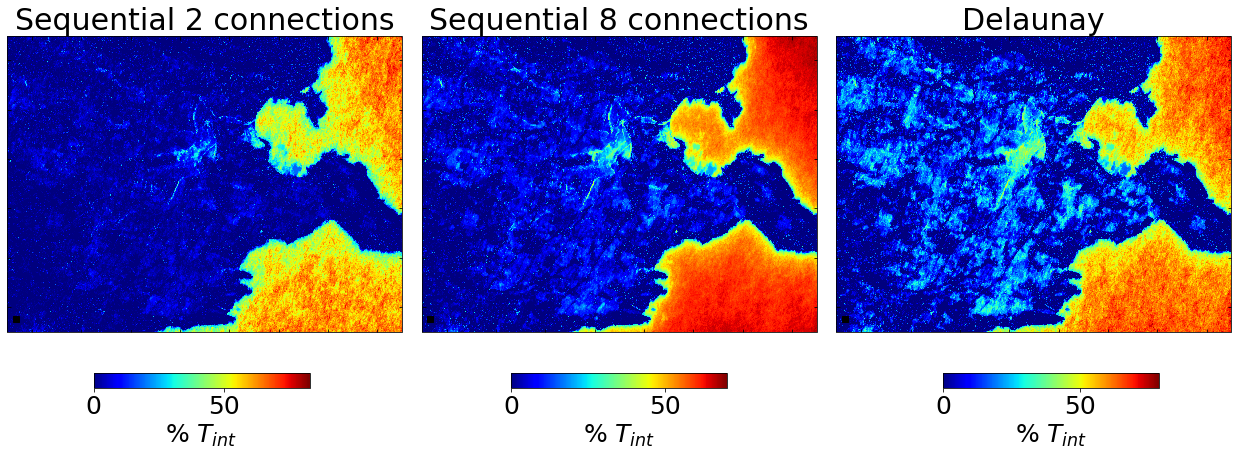

In [5]:
plt.rcParams["font.size"] = "25"

box = ['36.97:37.09','15.17:15.33']
reflat = 37.0901
reflon = 15.2864

lat = [float(i) for i in box[0].split(':')]
lon = [float(i) for i in box[1].split(':')]

opt = ' --notitle --nocbar --alpha 1 '
opt += ' --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature '
opt += ' --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noscalebar'
opt += ' --noverbose --nomultilook ' #.format(reflat, reflon)


fig, axs = plt.subplots(nrows=1, ncols=3, 
                        figsize=(20,10.3), subplot_kw=dict(projection=ccrs.PlateCarree()))


ax = axs[0]
ax.set_extent([lon[0], lon[1], lat[0], lat[1]], crs=ccrs.PlateCarree())
data_lass = prj_dirs[2] + '/new/geo/geo_Trip_perc.h5'
mask_file = prj_dirs[2] + '/new/geo/geo_maskTempCoh.h5'
opt = ' --notitle --nocbar --alpha 1 '
opt += ' --lalo-step 0.02 --lalo-loc 0 0 0 0 -c jet '
opt += ' --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noscalebar'
opt += ' --noverbose --nomultilook ' #.format(reflat, reflon)
cmd = 'view.py {}'.format(data_lass) + opt 
cmd += ' --sub-lat {} {} --sub-lon {} {} '.format(lat[0], lat[1], lon[0], lon[1])
d_v, atr, inps = view.prep_slice(cmd)
im, cbar = view.plot_slice(ax, d_v, atr, inps)[2:4]
ax.set_title('Sequential 2 connections')

cbar_ax = fig.add_axes([0.16, 0.25, 0.15, 0.02])
fig.colorbar(im, cax=cbar_ax, label='% $T_{int}$', orientation='horizontal')




ax = axs[1]
data_lass = prj_dirs[3] + '/new/geo/geo_Trip_perc.h5'
mask_file = prj_dirs[3] + '/new/geo/geo_maskTempCoh.h5'
opt = ' --notitle --nocbar --alpha 1 '
opt += ' --lalo-step 0.02 --lalo-loc 0 0 0 0 -c jet '
opt += ' --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noscalebar'
opt += ' --noverbose --nomultilook ' #.format(reflat, reflon)
cmd = 'view.py {}'.format(data_lass) + opt 
cmd += ' --sub-lat {} {} --sub-lon {} {} '.format(lat[0], lat[1], lon[0], lon[1])
d_v, atr, inps = view.prep_slice(cmd)
im, cbar = view.plot_slice(ax, d_v, atr, inps)[2:4]
ax.set_title('Sequential 8 connections')
cbar_ax = fig.add_axes([0.45, 0.25, 0.15, 0.02])
fig.colorbar(im, cax=cbar_ax, label='% $T_{int}$', orientation='horizontal')




ax = axs[2]
data_lass = prj_dirs[4] + '/../geo/geo_Trip_perc.h5'
mask_file = prj_dirs[4] + '/../geo/geo_maskTempCoh.h5'
opt = ' --notitle --nocbar --alpha 1 '
opt += ' --lalo-step 0.02 --lalo-loc 0 0 0 0 -c jet '
opt += ' --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noscalebar'
opt += ' --noverbose --nomultilook ' #.format(reflat, reflon)
cmd = 'view.py {}'.format(data_lass) + opt 
cmd += ' --sub-lat {} {} --sub-lon {} {} '.format(lat[0], lat[1], lon[0], lon[1])
d_v, atr, inps = view.prep_slice(cmd)
im, cbar = view.plot_slice(ax, d_v, atr, inps)[2:4]
ax.set_title('Delaunay')
cbar_ax = fig.add_axes([0.75, 0.25, 0.15, 0.02])
fig.colorbar(im, cax=cbar_ax, label='% $T_{int}$', orientation='horizontal')



fig.subplots_adjust(wspace=0.05, hspace=0.3, left=0.1, right=0.95, top=0.95, bottom=0.1)      
plt.savefig(out_dir +'/Trilets_percentage.png', bbox_inches='tight', dpi=300) 


view.py /Users/Sara/Documents/insarlab/scratch/SicilySenDT124/minopy_seq_2/new/geo/geo_numTriNonzeroIntAmbiguity.h5 --notitle --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c jet --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noscalebar --noverbose --nomultilook --sub-lat 36.97 37.09 --sub-lon 15.17 15.33
view.py /Users/Sara/Documents/insarlab/scratch/SicilySenDT124/minopy_seq_8/new/geo/geo_numTriNonzeroIntAmbiguity.h5 --notitle --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c jet --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noscalebar --noverbose --nomultilook --sub-lat 36.97 37.09 --sub-lon 15.17 15.33
view.py /Users/Sara/Documents/insarlab/scratch/SicilySenDT124/delaunay_4_network/geocoded/../geo/geo_numTriNonzeroIntAmbiguity.h5 --notitle --nocbar --alpha 1 --lalo-step 0.02 --lalo-loc 0 0 0 0 -c jet --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noscalebar --noverbose --nomultilook --sub-lat 36.97 37.09 --sub-lon 15.17 15.33


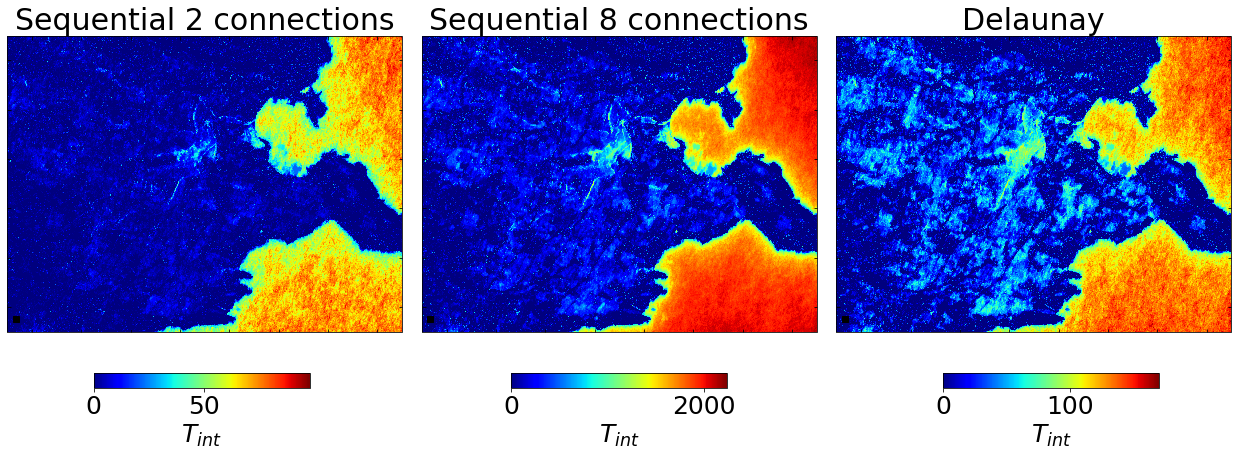

In [4]:
plt.rcParams["font.size"] = "25"

box = ['36.97:37.09','15.17:15.33']
reflat = 37.0901
reflon = 15.2864

lat = [float(i) for i in box[0].split(':')]
lon = [float(i) for i in box[1].split(':')]

opt = ' --notitle --nocbar --alpha 1 '
opt += ' --lalo-step 0.02 --lalo-loc 0 0 0 0 -u cm -c temperature '
opt += ' --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noscalebar'
opt += ' --noverbose --nomultilook ' #.format(reflat, reflon)


fig, axs = plt.subplots(nrows=1, ncols=3, 
                        figsize=(20,10.3), subplot_kw=dict(projection=ccrs.PlateCarree()))


ax = axs[0]
ax.set_extent([lon[0], lon[1], lat[0], lat[1]], crs=ccrs.PlateCarree())
data_lass = prj_dirs[2] + '/new/geo/geo_numTriNonzeroIntAmbiguity.h5'
mask_file = prj_dirs[2] + '/new/geo/geo_maskTempCoh.h5'
opt = ' --notitle --nocbar --alpha 1 '
opt += ' --lalo-step 0.02 --lalo-loc 0 0 0 0 -c jet '
opt += ' --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noscalebar'
opt += ' --noverbose --nomultilook ' #.format(reflat, reflon)
cmd = 'view.py {}'.format(data_lass) + opt 
cmd += ' --sub-lat {} {} --sub-lon {} {} '.format(lat[0], lat[1], lon[0], lon[1])
d_v, atr, inps = view.prep_slice(cmd)
im, cbar = view.plot_slice(ax, d_v, atr, inps)[2:4]
ax.set_title('Sequential 2 connections')

cbar_ax = fig.add_axes([0.16, 0.25, 0.15, 0.02])
fig.colorbar(im, cax=cbar_ax, label='$T_{int}$', orientation='horizontal')




ax = axs[1]
data_lass = prj_dirs[3] + '/new/geo/geo_numTriNonzeroIntAmbiguity.h5'
mask_file = prj_dirs[3] + '/new/geo/geo_maskTempCoh.h5'
opt = ' --notitle --nocbar --alpha 1 '
opt += ' --lalo-step 0.02 --lalo-loc 0 0 0 0 -c jet '
opt += ' --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noscalebar'
opt += ' --noverbose --nomultilook ' #.format(reflat, reflon)
cmd = 'view.py {}'.format(data_lass) + opt 
cmd += ' --sub-lat {} {} --sub-lon {} {} '.format(lat[0], lat[1], lon[0], lon[1])
d_v, atr, inps = view.prep_slice(cmd)
im, cbar = view.plot_slice(ax, d_v, atr, inps)[2:4]
ax.set_title('Sequential 8 connections')
cbar_ax = fig.add_axes([0.45, 0.25, 0.15, 0.02])
fig.colorbar(im, cax=cbar_ax, label='$T_{int}$', orientation='horizontal')




ax = axs[2]
data_lass = prj_dirs[4] + '/../geo/geo_numTriNonzeroIntAmbiguity.h5'
mask_file = prj_dirs[4] + '/../geo/geo_maskTempCoh.h5'
opt = ' --notitle --nocbar --alpha 1 '
opt += ' --lalo-step 0.02 --lalo-loc 0 0 0 0 -c jet '
opt += ' --scalebar 0.28 0.18 0.04 --scalebar-pad 0.05 --noscalebar'
opt += ' --noverbose --nomultilook ' #.format(reflat, reflon)
cmd = 'view.py {}'.format(data_lass) + opt 
cmd += ' --sub-lat {} {} --sub-lon {} {} '.format(lat[0], lat[1], lon[0], lon[1])
d_v, atr, inps = view.prep_slice(cmd)
im, cbar = view.plot_slice(ax, d_v, atr, inps)[2:4]
ax.set_title('Delaunay')
cbar_ax = fig.add_axes([0.75, 0.25, 0.15, 0.02])
fig.colorbar(im, cax=cbar_ax, label='$T_{int}$', orientation='horizontal')



fig.subplots_adjust(wspace=0.05, hspace=0.3, left=0.1, right=0.95, top=0.95, bottom=0.1)      
plt.savefig(out_dir +'/Trilets_sicily.png', bbox_inches='tight', dpi=300) 
